In [260]:
import os
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

In [261]:
print(torch.version.cuda)

11.8


In [262]:
#load saved files
fname = 0

with open(f'{fname}_x.pkl', 'rb') as f:
    firing_rates_all_stim = pickle.load(f)
    
with open(f'{fname}_y.pkl', 'rb') as f:
    y_np = pickle.load(f)

In [263]:
y_np.shape

(4435,)

In [264]:
firing_rates_all_stim.shape

(4435, 49, 252)

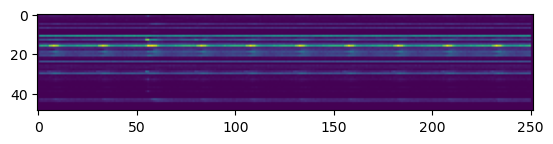

In [265]:
plt.imshow(np.mean(firing_rates_all_stim, axis = 0))

(array([32.,  8.,  2.,  5.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([9.92108230e-04, 2.25478241e+00, 4.50857272e+00, 6.76236302e+00,
        9.01615333e+00, 1.12699436e+01, 1.35237339e+01, 1.57775242e+01,
        1.80313145e+01, 2.02851048e+01, 2.25388952e+01]),
 <BarContainer object of 10 artists>)

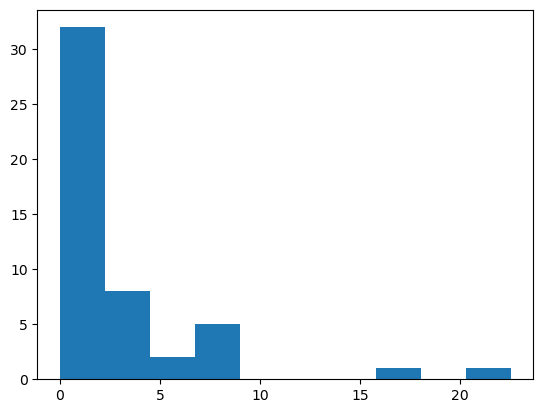

In [266]:
plt.hist(np.mean(np.sum(firing_rates_all_stim, axis = 2), axis = 0)/2.5)

In [267]:
firing_rates_all_stim.shape

(4435, 49, 252)

In [268]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [269]:
print(torch.version.cuda)

11.8


In [270]:
#format data as tensor of reordered dims
firing_rates = torch.from_numpy(firing_rates_all_stim).permute(2, 0, 1) 
firing_rates = firing_rates.to(torch.float32)
firing_rates.shape

torch.Size([252, 4435, 49])

In [271]:
#train test split
train_split = .8
all_ids = np.arange(firing_rates.shape[1])
np.random.shuffle(all_ids)
train_ids = all_ids[0:int(len(all_ids) * train_split)]
test_ids = all_ids[int(len(all_ids) * train_split):-1]

In [272]:
# #get temp X: sum firing rate
# X = torch.sum(firing_rates, axis = 0)
# X.shape


In [273]:
#format y as one hot encoding
y = F.one_hot(torch.from_numpy(y_np))
y = y.to(torch.float32)

In [274]:
n_neurons = 49
n_bins = 252
input_dim = n_neurons * n_bins
input_dim

12348

In [ ]:
#define model architecture
#should switch to cnn to reduce dims at first, as overparametrization is questionable for now
class Net(nn.Module):
    def __init__(self, n_comps, input_dim, output_cats):
        super(Net, self).__init__()
        
        #layers
        self.fc1 = nn.Linear(input_dim, 2*input_dim)  #input layer, apparently multi-dim inputs should be accepted #let's go wider
        self.fc2 = nn.Linear(2*input_dim, n_comps)    #hidden layer #let's go to latent comps
        self.fc3 = nn.Linear(n_comps, output_cats)      #output layer
    
    def forward(self, x):
        x = torch.flatten(x, 1) #flatten params
        # print(x.shape)
        x = F.leaky_relu(self.fc1(x))
        # print(f'out1 shape: {out.shape}')
        x = F.leaky_relu(self.fc2(x))
        # print(f'out2 shape: {out.shape}')
        x = self.fc3(x) #apparently softmax is already applied in crossentropy F.softmax(x, dim = 1)
        # print(f'out3 shape: {out.shape}')
        # print(f'out3: {out}')
        return x

In [276]:
#param for dataloader
batch_size = 32

In [277]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NeuralData(Dataset):
    def __init__(self, train = True):
        if train:
            self.firing_rate = firing_rates[:, train_ids, :]
            self.labels = y[train_ids]
        else:
            self.firing_rate = firing_rates[:, test_ids, :]
            self.labels = y[test_ids]
    
    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        rate = self.firing_rate[:, idx]
        # rate = torch.sum(self.firing_rate, axis = 0)[idx]
        label = self.labels[idx]
        return rate, label
    
train_data = NeuralData(train = True)
test_data = NeuralData(train = False)

train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

In [278]:
#params

#n of latent comps to try
n_comps = 5
output_cats = 4
n_neurons = firing_rates.shape[-1]
learning_rate = 1e-3
lambda_l2 = 5e-3
num_epochs = 200

In [279]:
#create model
model = Net(n_comps = n_comps, input_dim = input_dim, output_cats = output_cats)

In [280]:
#loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
loss_list = []
loss_increase = 0
prev_loss = 5
earlystop_criterion = 20 #how many iters of loss worsening before stopping

#add early stopping

#train
for epoch in tqdm.tqdm(range(num_epochs)):
    #iterate through train data
    for rate, label in train_loader:
        # print(rate.shape, label.shape)
        #forward pass 
        pred = model(rate)
        l2 = 0
        for p in model.parameters():
            l2 += torch.sum(p ** 2)
        loss = criterion(pred, label) + lambda_l2 * l2
        loss_list.append(loss.item())
        
        #early stopping
        
        if loss > prev_loss:
            loss_increase += 1
            prev_loss = loss
            if loss_increase > earlystop_criterion:
                print(f'Early stop at epoch {epoch}, loss = {loss}, didn\'t improve for {earlystop_criterion} iterations')            
        else:
            loss_increase = 0
            prev_loss = loss
            
        
        #backprop
        optimizer.zero_grad() #zero out grads
        loss.backward() #calculate grad
        optimizer.step() #take step
        
        # track accuracy
        total = label.size(0)
        _, predicted = torch.max(pred.data, 1)
        correct = (predicted == label).sum().item()
        acc_list.append(correct / total)
        
    print(f'epoch: {epoch}, loss: {loss}')

Text(0, 0.5, 'loss, cross entropy + L2')

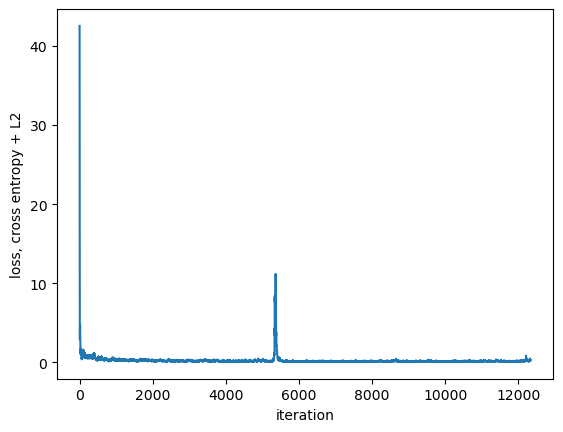

In [282]:
plt.plot(loss_list)
plt.xlabel('iteration')
plt.ylabel('loss, cross entropy + L2')

In [303]:
# testing
model.eval()
model.to(device)
real_labels, predicted_labels = [], []
with torch.no_grad():
  correct = 0
  total = 0
  for rate, labels in test_loader:
    #load labels
    rate, labels = rate.to(device), labels.to(device)
    val, labels = torch.max(labels.data, 1)
    real_labels += list(labels.cpu().numpy())
    #get preds
    preds = model(rate)
    val, predicted = torch.max(preds.data, 1)
    predicted_labels += list(predicted.cpu().numpy())
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print(f"test acc from rates: {(correct / total)*100:.3f}%")

test acc from rates: 99.210%


In [ ]:
from sklearn.metrics import confusion_matrix

plt.imshow(confusion_matrix(real_labels, predicted_labels, normalize = 'true'))
print(confusion_matrix(real_labels, predicted_labels, normalize = 'true'))

NameError: name 'plt' is not defined

In [ ]:
#save model just in case
# with open('model.pkl', 'wb') as f:
#     pickle.dump(model, f)

In [287]:
for i, layer in enumerate(model.parameters()):
    print(f'layer {i} num of params: {torch.numel(layer)}')

layer 0 num of params: 304946208
layer 1 num of params: 24696
layer 2 num of params: 123480
layer 3 num of params: 5
layer 4 num of params: 20
layer 5 num of params: 4
